In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def HoG_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cell_size = (4,4) #size of cells measured in pixels
    block_size = (4,4)  #size of a block measured in cells
    nbins = 8 #number of bins
    height = image.shape[0]
    width = image.shape[1]
    
    #create the Histogram of Oriented Gradients object
    #winSize is the size of the window (already a multiple of cell size)
    #blockSize is the size of a single block in pixels
    #set blockStride to simply be the size of one cell
    #set cellSize based on above size
    hog = cv2.HOGDescriptor(_winSize=(width,height),_blockSize=(block_size[1] * cell_size[1],block_size[0] * cell_size[0]),
                        _blockStride=(cell_size),
                        _cellSize=(cell_size),
                        _nbins=nbins)
    
    #compute the number of cells based on the image size and the size of each of the cells
    n_cells = (height // cell_size[0], width // cell_size[1])
    
    # Compute HoG features
    hog_feats = hog.compute(image)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    
    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1
    
    # Average gradients
    hog_feats = hog_feats.flatten()
    
    
    return hog_feats, gradients, cell_count


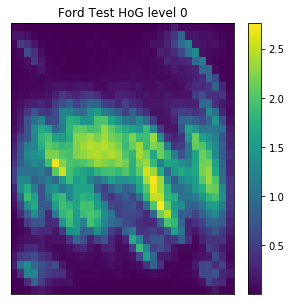

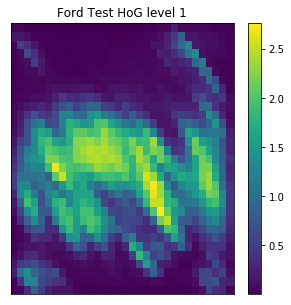

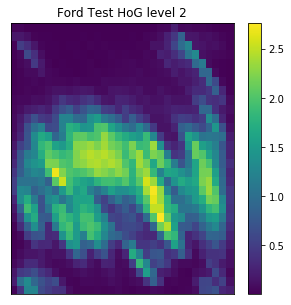

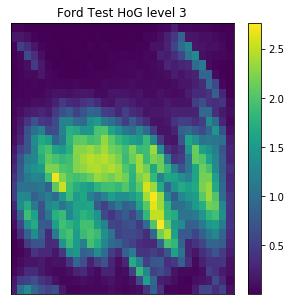

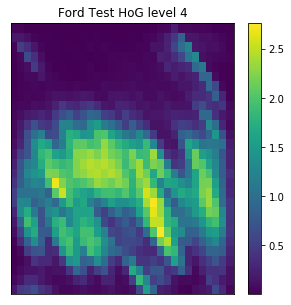

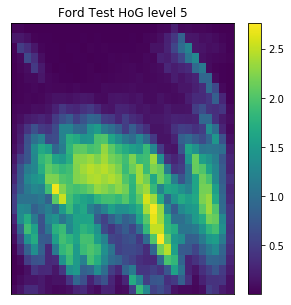

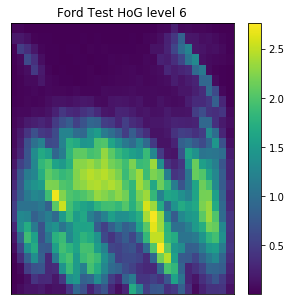

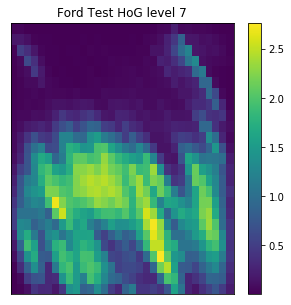

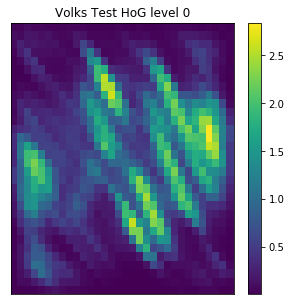

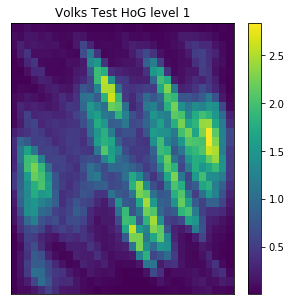

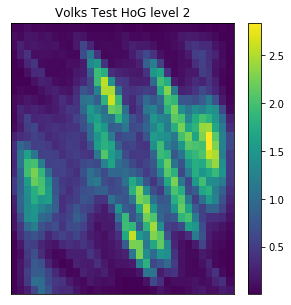

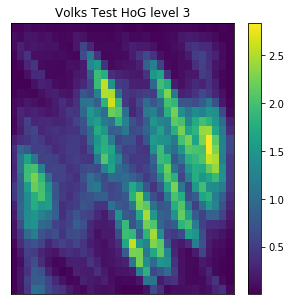

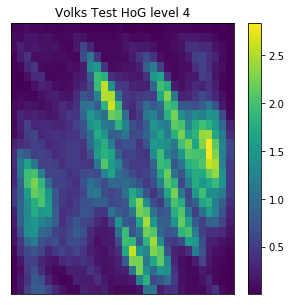

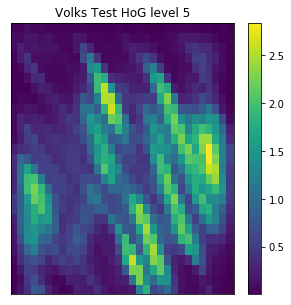

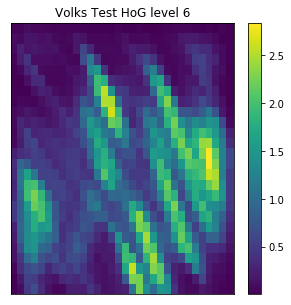

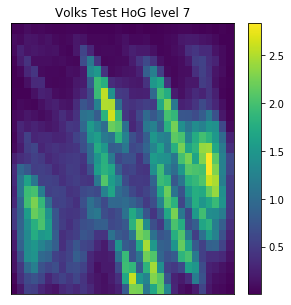

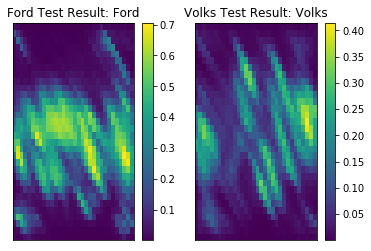

In [3]:
image_list_ford = []
image_list_volks = []
image_list = []
test_list = []

#import all of the images which are part of the training set into two seperate lists (one of ford one of volks)
#import test images to other list
for filename in glob.glob('dataset/*.*'):
    if(filename != "dataset/ford_test.jpeg" and filename != "dataset/volks_test.jpeg"):
        if(filename != "dataset/volks_train1.jpeg" and filename != "dataset/volks_train2.jpeg" and filename != "dataset/volks_train3.jpeg" and filename != "dataset/volks_train4.jpeg" and filename != "dataset/volks_train5.jpeg"):
            nextImage = cv2.imread(filename)
            image_list_ford.append(nextImage)
        else:
            nextImage = cv2.imread(filename)
            image_list_volks.append(nextImage)
    else:
        nextImage = cv2.imread(filename)
        test_list.append(nextImage) 

#put all ford images into list in a row
for i in range (len(image_list_ford)):
    image_list.append(image_list_ford[i])
    
#put all volks objects into list in a row
for i in range (len(image_list_volks)):
    image_list.append(image_list_volks[i])
    
#resize all of the images so that they are of size (128,128)
resized_image_list = []
resized_test_list = []

for i in image_list:
    newImage = cv2.resize(i,(128,128))
    resized_image_list.append(newImage)

for i in test_list:
    newImage = cv2.resize(i,(128,128))
    resized_test_list.append(newImage)
    
#find HoG features for each of the training images
HoG_list = []
HoG_test_list = []
gradient_test_list = []
cell_count_list = []
for i in range(len(resized_image_list)):
    newFeatures, _,_ = HoG_features(resized_image_list[i])
    HoG_list.append(newFeatures)

#find all the HoG features for each of the test images  
for i in range(len(resized_test_list)):
    newFeatures, gradients, cell_count_list = HoG_features(resized_test_list[i])
    HoG_test_list.append(newFeatures)
    gradient_test_list.append(gradients)
    
#create training list set with all five ford's first then all five volks
Y = ["Ford","Ford","Ford","Ford","Ford","Volks","Volks","Volks","Volks","Volks"]

#create the KNeighbors object
neighour = KNeighborsClassifier(n_neighbors=3)

#fit the model using the training images
neighour.fit(HoG_list, Y) 

#predict how the two images are classified
prediction = neighour.predict(HoG_test_list)

bin = 0

#plot each of the gradients for the HoG for the first test image
for i in range(0, 8):
    plt.figure(figsize=(5,5))
    plt.pcolor(gradient_test_list[0][i:, :, bin])
    plt.title("Ford Test HoG level " + str(i)), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()
    
#plot each of the gradients for the HoG for the second test image
for i in range(0, 8):
    plt.figure(figsize=(5,5))
    plt.pcolor(gradient_test_list[1][i:, :, bin])
    plt.title("Volks Test HoG level " + str(i)), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()

#flatten the gradients so they can be distplayed with the result of the test images
gradient_test_list[0] /= cell_count_list[0]
gradient_test_list[1] /= cell_count_list[1]

#plot the two images with their test results
plt.subplot(121)
plt.pcolor(gradient_test_list[0][:, :, bin])
plt.title("Ford Test Result: "+ prediction[0]), plt.xticks([]), plt.yticks([])
plt.colorbar()

plt.subplot(122)
plt.pcolor(gradient_test_list[1][:, :, bin])
plt.title("Volks Test Result: "+ prediction[1]), plt.xticks([]), plt.yticks([])
plt.colorbar()

Reasoning Questions:

(1) HoG is not rotation invariant. As such, one cannot expect success from using HoG on the images if they were to be rotated by random angles prior to performing the analysis. As such, one must first make sure to rotate all of the images to be in the same orientation. This can be done using feature matching with SIFT or SURF features. One could match the keypoints of the images and then rotate the images so that the keypoints line up with each other in much the same way that homography is performed to line up the images to be stitched together. At this point, when all the images are of the same orientation one can perform HoG analysis.

(2) In order to accurately classify the images into three sets one would need to have 3 directions of gradients, one horizontal, one perpendicular to one of the diagonals and one perpendicular to the other of the diagonals.